In [1]:
!pip install --upgrade tensorflow --user
!pip install tf-quant-finance
!pip install QuantLib-Python

In [2]:
import os
# reduce number of threads
os.environ['TF_NUM_INTEROP_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tf_quant_finance as tff 
import tensorflow as tf
import functools
import pandas as pd
import time
import QuantLib as ql

In [3]:
!nvidia-smi

Mon Apr  4 15:03:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#@title Set up parameters

dtype = tf.float64 #@param
num_samples = 200000 #@param
num_timesteps = 100#100 #@param
nb_options = 20

# expiries =tf.constant( [0.0, 0.5, 1.0], dtype=dtype) # This can be a rank 1 Tensor
dt = 1. / num_timesteps
times = [1.0]
# times = tf.linspace(tf.constant(0.0, dtype=dtype), tf.constant(1.0, dtype=dtype), num_timesteps)
rate = tf.constant(0.03, dtype=dtype)
sigma = tf.constant(0.1, dtype=dtype)
spot = tf.constant(700, dtype=dtype)
strikes = tf.linspace(0.5*spot, 1.5*spot, nb_options)

def set_up_pricer(times, watch_params=False):
    """Set up European option pricing function under Black-Scholes model.
    
    Args:
        expiries: List of expiries at which to to sample the trajectories.
        watch_params: A Python bool. When `True`, gradients of the price function wrt the inputs
          are computed more efficiently. 
    Returns:
     A callable that accepts a rank 1 tensor of strikes, and scalar values for 
     the spots and  volatility values. The callable outputs prices of
     the European call options on the grid `expiries x strikes`.
    """
    def price_eu_options(strikes, spot, sigma):
        # Define drift and volatility functions. 
        def drift_fn(t, x):
          del t, x
          return rate - 0.5 * sigma**2
        def vol_fn(t, x):
          del t, x
          return tf.reshape(sigma, [1, 1])
        # Use GenericItoProcess class to set up the Ito process
        process = tff.models.GenericItoProcess(
            dim=1,
            drift_fn=drift_fn,
            volatility_fn=vol_fn,
            dtype=dtype)
        log_spot = tf.math.log(tf.reduce_mean(spot))
        if watch_params:
            watch_params_list = [sigma]
        else:
            watch_params_list = None
        paths = process.sample_paths(
            times=times, num_samples=num_samples,
            initial_state=log_spot, 
            watch_params=watch_params_list,
            # Select a random number generator
            random_type=tff.math.random.RandomType.PSEUDO_ANTITHETIC,
            time_step=dt)
        prices = (tf.exp(-tf.expand_dims(rate * times, axis=-1))
                  * tf.reduce_mean(tf.nn.relu(tf.math.exp(paths) - strikes), 0))
        return prices
    return price_eu_options

price_eu_options = tf.function(set_up_pricer(times, watch_params=True),
                               input_signature=[
                                                tf.TensorSpec([None], dtype=tf.float64),
                                                tf.TensorSpec([], dtype=tf.float64),
                                                tf.TensorSpec([], dtype=tf.float64)
                               ])
# price_eu_options2 = tf.function(set_up_pricer(times),
#                                input_signature=[
#                                                 tf.TensorSpec([None], dtype=tf.float64),
#                                                 tf.TensorSpec([], dtype=tf.float64),
#                                                 tf.TensorSpec([], dtype=tf.float64)
#                                ])
# price_eu_options_xla = tf.function(set_up_pricer(times), jit_compile=True)
# price_eu_options = set_up_pricer(times)
# price_eu_options_xla = set_up_pricer(times)

In [6]:
#@title Pricing times on CPU and GPU platforms

time_start = time.time()
with tf.device("/cpu:0"):
    price_cpu_nograph = set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_cpu_nograph = time_end - time_start
print(price_cpu_nograph[:10].numpy())

time_start = time.time()
with tf.device("/gpu:0"):
    set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_gpu_nograph = time_end - time_start

# GPU without XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_cpu = time_end - time_start

print('time_price_cpu_nograph', time_price_cpu_nograph, nb_options/time_price_cpu_nograph)
print('time_price_gpu_nograph', time_price_gpu_nograph, nb_options/time_price_gpu_nograph)

print('time_price_gpu0', time_price_gpu0, nb_options/time_price_gpu0)
print('time_price_gpu', time_price_gpu, nb_options/time_price_gpu)

print('time_price_cpu0', time_price_cpu0, nb_options/time_price_cpu0)
print('time_price_cpu', time_price_cpu, nb_options/time_price_cpu)


[[3.60319066e+02 3.24565810e+02 2.88812553e+02 2.53059297e+02
  2.17307030e+02 1.81574981e+02 1.46000286e+02 1.11177322e+02
  7.85916030e+01 5.05631848e+01 2.91369547e+01 1.49626958e+01
  6.82280648e+00 2.77493138e+00 1.01090328e+00 3.31677143e-01
  9.96476906e-02 2.69942388e-02 6.11287331e-03 9.41367164e-04]]
time_price_cpu_nograph 6.282006025314331 3.183696405162118
time_price_gpu_nograph 2.1451869010925293 9.323196962378493
time_price_gpu0 16.639408111572266 1.2019658311097334
time_price_gpu 0.7570235729217529 26.419256566621115
time_price_cpu0 2.9572482109069824 6.763044078016717
time_price_cpu 2.8153645992279053 7.103875642069544


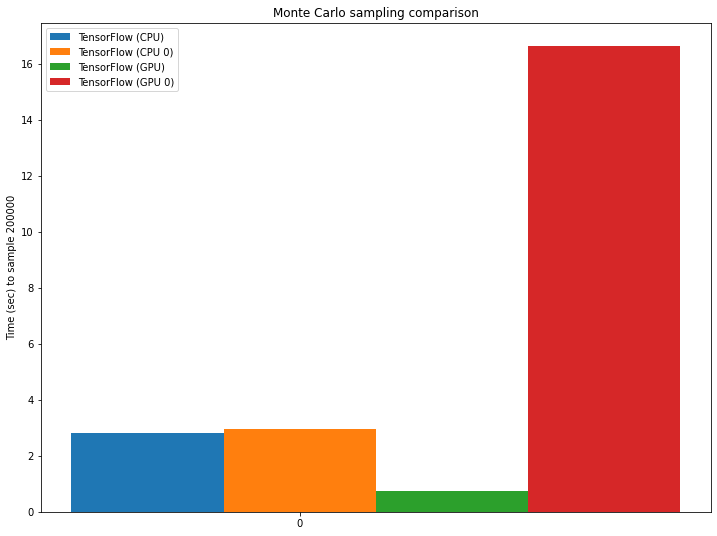

In [7]:
#@title Plot the results

ind = np.arange(1)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

fig.set_figheight(9)
fig.set_figwidth(12)

ax.bar(ind - width/8, [time_price_cpu], width / 8,
       label='TensorFlow (CPU)')
ax.bar(ind, [time_price_cpu0], width / 8,
       label='TensorFlow (CPU 0)')
ax.bar(ind + width/8, [time_price_gpu], width / 8,
       label='TensorFlow (GPU)')
ax.bar(ind + width/4, [time_price_gpu0], width / 8,
       label='TensorFlow (GPU 0)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (sec) to sample {}'.format(num_samples))
ax.set_title('Monte Carlo sampling comparison')
ax.set_xticks(ind)
ax.legend()


plt.show()

In [8]:
# Delta
@tf.function
def delta_fn(spot):
    fn = lambda spot: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, spot,
                                 use_gradient_tape=True)
# Theta # not tested in https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb
# Rho # not tested in https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb
# Vega
@tf.function
def vega_fn(sigma):
    fn = lambda sigma: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, sigma,
                                 use_gradient_tape=True)


In [17]:
# Delta CPU
## warmup
with tf.device("/cpu:0"):
    delta_fn(spot)
## measure time
time_start = time.time()
with tf.device("/cpu:0"):
    deltas_cpu = delta_fn(spot)
time_end = time.time()
time_delta_cpu = time_end - time_start


# Vega CPU
## warmup
with tf.device("/cpu:0"):
    vega_fn(sigma)
## measure time
time_start = time.time()
with tf.device("/cpu:0"):
    vegas_cpu = vega_fn(sigma)
time_end = time.time()
time_vega_cpu = time_end - time_start


# Delta GPU
## warmup
with tf.device("/gpu:0"):
    delta_fn(spot)
## measure time
time_start = time.time()
with tf.device("/gpu:0"):
    deltas_gpu = delta_fn(spot)
time_end = time.time()
time_delta_gpu = time_end - time_start

# Vega GPU
## warmup
with tf.device("/gpu:0"):
    vega_fn(sigma)
## measure time
time_start = time.time()
with tf.device("/gpu:0"):
    vegas_gpu = vega_fn(sigma)
time_end = time.time()
time_vega_gpu = time_end - time_start



print('time_delta_cpu', time_delta_cpu, nb_options/time_delta_cpu)
print('time_vega_cpu', time_vega_cpu, nb_options/time_vega_cpu)
print('time_delta_gpu', time_delta_gpu, nb_options/time_delta_gpu)
print('time_vega_gpu', time_vega_gpu, nb_options/time_vega_gpu)

print(deltas_cpu)
print(vegas_cpu)
print(deltas_gpu)
print(vegas_gpu)

time_delta_cpu 7.697009086608887 2.598411899343555
time_vega_cpu 7.8076794147491455 2.561580584650911
time_delta_gpu 2.184443950653076 9.155648051313317
time_vega_gpu 2.18476939201355 9.154284233892252
tf.Tensor(
[[1.00000131e+00 1.00000131e+00 1.00000131e+00 9.99998117e-01
  9.99913616e-01 9.98860988e-01 9.91310426e-01 9.61115044e-01
  8.79470136e-01 7.31808502e-01 5.35954680e-01 3.40272026e-01
  1.88009842e-01 8.95010994e-02 3.75116571e-02 1.45341422e-02
  4.98234653e-03 1.48350088e-03 4.10479344e-04 1.25826503e-04]], shape=(1, 20), dtype=float64)
tf.Tensor(
[[6.87420024e-02 6.87420024e-02 6.87420024e-02 8.93048381e-02
  3.04287143e-01 2.81756393e+00 1.64771879e+01 5.95815806e+01
  1.40573701e+02 2.30557772e+02 2.78045760e+02 2.56560102e+02
  1.88650620e+02 1.14721282e+02 5.75694211e+01 2.56821237e+01
  9.91649750e+00 3.55678184e+00 1.13801773e+00 2.88039505e-01]], shape=(1, 20), dtype=float64)
tf.Tensor(
[[1.00002139e+00 1.00002139e+00 1.00002139e+00 1.00001518e+00
  9.99914334e-01 

In [19]:
# GPU without XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
    delta_fn(spot)
    vega_fn(sigma)
time_end = time.time()
time_pricegreek_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
    delta_fn(spot)
    vega_fn(sigma)
time_end = time.time()
time_pricegreek_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
    deltas = delta_fn(spot)
    vegas = vega_fn(sigma)
time_end = time.time()
time_pricegreek_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options(strikes, spot, sigma)
    delta_fn(spot)
    vega_fn(sigma)
time_end = time.time()
time_pricegreek_cpu = time_end - time_start

print('time_pricegreek_gpu0', time_pricegreek_gpu0, nb_options/time_pricegreek_gpu0)
print('time_pricegreek_cpu0', time_pricegreek_cpu0, nb_options/time_pricegreek_cpu0)
print('time_pricegreek_gpu', time_pricegreek_gpu, nb_options/time_pricegreek_gpu)
print('time_pricegreek_cpu', time_pricegreek_cpu, nb_options/time_pricegreek_cpu)

print('prices', prices)
print('deltas', deltas)
print('vegas', vegas)

time_pricegreek_gpu0 6.948963642120361 2.8781270172104874
time_pricegreek_cpu0 17.898414611816406 1.1174174044887832
time_pricegreek_gpu 5.135654449462891 3.8943430086289563
time_pricegreek_cpu 17.61156678199768 1.1356173046706863
prices tf.Tensor(
[[3.60348251e+02 3.24594995e+02 2.88841738e+02 2.53088611e+02
  2.17337295e+02 1.81605982e+02 1.46039347e+02 1.11241212e+02
  7.86818934e+01 5.06514386e+01 2.92618596e+01 1.50495417e+01
  6.91138062e+00 2.84606504e+00 1.05223843e+00 3.48500217e-01
  1.06712608e-01 3.00089486e-02 9.26070663e-03 2.77825207e-03]], shape=(1, 20), dtype=float64)
deltas tf.Tensor(
[[1.00002778e+00 1.00002778e+00 1.00002778e+00 1.00002778e+00
  9.99926640e-01 9.98848251e-01 9.91404300e-01 9.60427447e-01
  8.78930517e-01 7.31166746e-01 5.36369112e-01 3.41243922e-01
  1.88136539e-01 9.09925360e-02 3.83394388e-02 1.43409394e-02
  4.88851411e-03 1.50649706e-03 4.90120035e-04 1.04753065e-04]], shape=(1, 20), dtype=float64)
vegas tf.Tensor(
[[4.02529115e-01 4.02529115e-0

In [12]:
# @title Monte Carlo sampling in QuantLib

def ql_price(strike):
    num_samples = 200000 #@param
    num_timesteps = 100#100 #@param
    expiry = 1.0

    calculation_date = ql.Date(1, 1, 2010)
    maturity_date = ql.Date(1, 1, 2011)
    day_count = ql.Thirty360()
    calendar = ql.NullCalendar()

    ql_strike_price = strike
    sigma_ql = 0.1
    ql_volatility = ql.SimpleQuote(sigma_ql)
    ql_risk_free_rate = 0.03
    option_type = ql.Option.Call

    ql.Settings.instance().evaluationDate = calculation_date
    payoff = ql.PlainVanillaPayoff(option_type, ql_strike_price)

    eu_exercise = ql.EuropeanExercise(maturity_date)
    european_option_ql = ql.VanillaOption(payoff, eu_exercise)

    flat_ts = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, ql_risk_free_rate, day_count)
    )
    flat_vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(calculation_date, calendar,
                            ql.QuoteHandle(ql_volatility), day_count)
    )

    spot_ql = 700
    spot_price = ql.SimpleQuote(spot_ql)
    spot_handle = ql.QuoteHandle(
        spot_price
    )
    bsm_process = ql.BlackScholesProcess(spot_handle,
                                          flat_ts,
                                          flat_vol_ts)

    # Compute the same price number_of_options times

    engine = ql.MCEuropeanEngine(bsm_process, "PseudoRandom",
                                 timeSteps=num_timesteps,
                                 requiredSamples=num_samples,
                                 seed=42)

    european_option_ql.setPricingEngine(engine)
    price_ql = european_option_ql.NPV()
    return price_ql

ql_prices = []
t = time.time()
for strike in strikes:
    price_ql = ql_price(strike.numpy())
    ql_prices.append(price_ql)
time_price_ql = time.time() - t
print(ql_prices)
print("Time (seconds) to price a European Call Option using QuantLib: ", time_price_ql, nb_options/time_price_ql)

[360.38096816219917, 324.6277116630422, 288.87445516388317, 253.12134260868683, 217.3691682407967, 181.6340389862479, 146.05831870323763, 111.23696256008365, 78.64597284368979, 50.63317577326372, 29.243318215156467, 15.022626670120085, 6.8551094727374275, 2.7778426510531573, 1.0155217324983004, 0.33489202186099365, 0.10166830402822762, 0.030473677573669908, 0.007918399213728616, 0.0017499648447671884]
Time (seconds) to price a European Call Option using QuantLib:  266.0508027076721 0.07517361269522402
